# MNIST Dataset Example <a name="MNIST-Dataset-Example-mnist"></a>
This example extends the scikit-learn notebook found in the base ``xaitk-saliency`` repo [here](https://github.com/XAITK/xaitk-saliency/blob/master/examples/MNIST_scikit_saliency.ipynb), and explores integrating ``xaitk-saliency`` with ``MLFlow`` to track model metrics and saliency maps.

## Set Up Environment <a name="Set-Up-Environment-mnist"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q mlflow
!{sys.executable} -m pip install -q matplotlib

## Downloading the Dataset <a name="Download-the-Dataset-mnist"></a>

The MNIST dataset consists of 70,000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

/home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


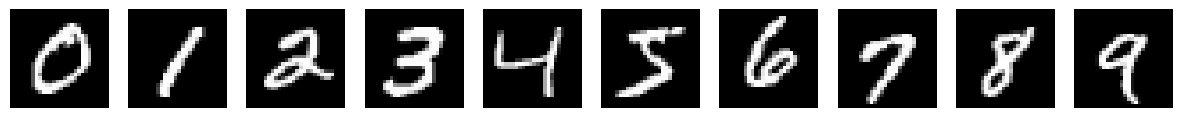

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
import os

cwd = os.getcwd()
data_dir = cwd + '/data/scikit-learn-example'

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, data_home=data_dir)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

# MLP Example <a name="MLP-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-mlp-mnist"></a>

Following the second [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we train an `MLPClassifier` on the MNIST dataset using the same hyperparameters.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not entirely converge.

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from pprint import pprint
import matplotlib.pyplot as plt  # type: ignore
from pathlib import Path

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

params = {"hidden_layer_sizes" : (50,), "max_iter" : 10, "alpha": 1e-4,
          "solver" :'sgd', "verbose": 10, "random_state": 1,
          "learning_rate_init" : .1}

mlp = MLPClassifier(**params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    x = mlp.fit(X_train, y_train)

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


## Black-Box Classifier <a name="Black-Box-Classifier-mlp-mnist"/></a>

We wrap our `MLPClassifier` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [4]:
from smqtk_classifier.interfaces.classify_image import ClassifyImage

class MNISTClassifierMLP (ClassifyImage):
    def get_labels(self):
        return list(range(10))
    
    def classify_images(self, img_iter):
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(img_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28*28)  # may fail because input was not the correct shape
        return (
            {idx: p_i for idx, p_i in zip(range(10), p)}
            for p in mlp.predict_proba(images)
        )
    
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier_mlp = MNISTClassifierMLP()

## The "Application" <a name="The-Application-mnist"></a>

Our "application" will accept a set of images, a black-box image classifier, and a saliency generator and will generate saliency maps for each image provided.
The saliency maps from the first image in the set will then be plotted to give an idea of the model's behavior on a single sample.

Additionally, because all digits in the MNIST dataset are centered in the frame, we can average all the heatmaps generated for each respective class to produce a decision boundary visualization.
The application will do this and plot the resulting averaged heatmaps for each digit class.

In [5]:
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency

def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency
):  

    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        sal_maps_set.append(sal_maps)
    
    num_classes = sal_maps_set[0].shape[0]
    
    # Plot first image in set with saliency maps
    fig1 = plt.figure(figsize=(10,5))
    plt.suptitle("Heatmaps for First Image", fontsize=16)
    num_cols = np.ceil(num_classes/2).astype(int) + 1
    plt.subplot(2, num_cols, 1)
    plt.imshow(images[0].reshape(28,28), cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    for c in range(num_cols - 1):
        plt.subplot(2, num_cols, c + 2)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    for c in range(num_classes - num_cols + 1, num_classes):
        plt.subplot(2, num_cols, c + 3)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    
    # Average heatmaps for each respective class
    global_maps = np.sum(sal_maps_set, axis=0) / len(images)
    
    # Plot average maps
    fig2 = plt.figure(figsize=(10, 5))
    plt.suptitle("Average Heatmaps from All Images", fontsize=16)
    for c in range(num_classes):
        vcap = np.absolute(global_maps[c]).max()
        plt.subplot(2, num_cols-1, c + 1)
        plt.imshow(global_maps[c], cmap=plt.cm.RdBu, vmin=-vcap, vmax=vcap)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    return fig1, fig2, sal_maps_set

## Heatmap Generation <a name="Heatmap-Generation-mnist"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [6]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(2, 2),
    stride=(1, 1),
    threads=4
)

## Calling the Application <a name="Calling-the-Application-mlp-mnist"></a>

We call our application using a small MNIST image subset, our saliency generator, and our MLP classifier.

The results show mostly negative saliency, suggesting that the MLP model has learned where the pixels are *absent* for each class more than where they are *present*.

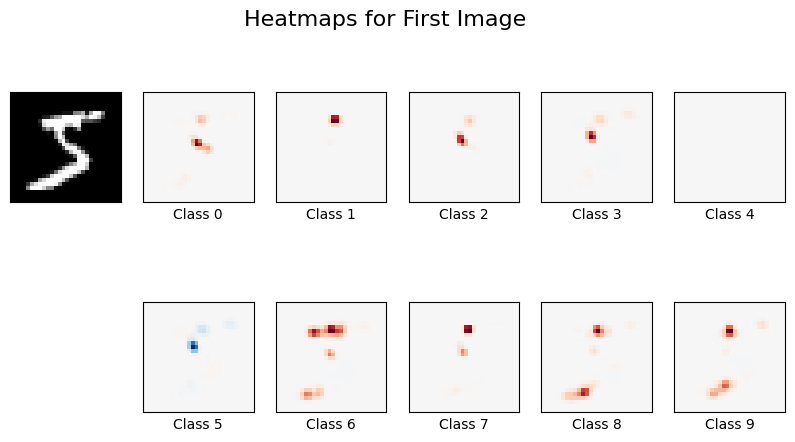

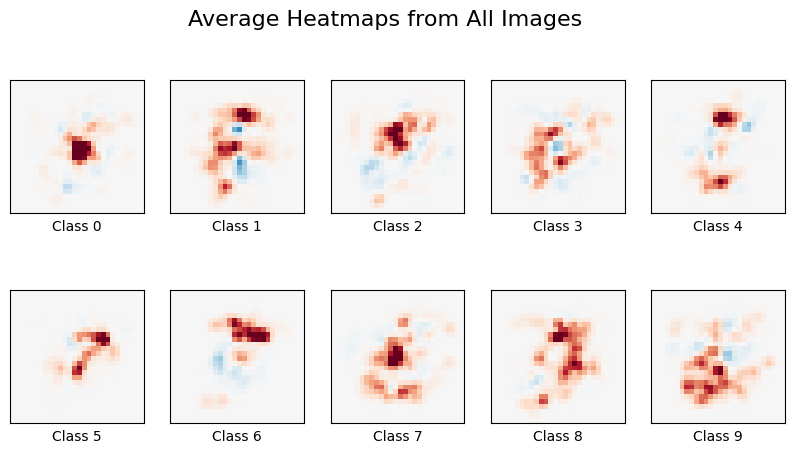

In [7]:
fig1, fig2, sal_maps = app(
    X[0:20],
    image_classifier_mlp,
    gen_slidingWindow
)

## Generating Saliency maps for a specific image <a name="Generate-Saliency-mlp-mnist"></a>

The `app` function from [The Application](#the-application) section is modified to generate class-wise saliency maps for a specific `image_id`.

In [8]:
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency
import matplotlib.pyplot as plt  # type: ignore

class GenerateSaliency():

    def gen_saliency_maps(self,
        image_id: int,
        img: np.ndarray,
        image_classifier: ClassifyImage,
        saliency_generator: GenerateImageClassifierBlackboxSaliency
    ):  

        # Generate saliency maps
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        
        num_classes = sal_maps.shape[0]
        
        # Plot nth image in set with saliency maps
        fig1 = plt.figure(figsize=(10,5))
        plt.suptitle(f"Saliency Maps for Image_ID: {str(image_id)}", fontsize=16)
        num_cols = np.ceil(num_classes/2).astype(int) + 1
        plt.subplot(2, num_cols, 1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
        for c in range(num_cols - 1):
            plt.subplot(2, num_cols, c + 2)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        for c in range(num_classes - num_cols + 1, num_classes):
            plt.subplot(2, num_cols, c + 3)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        
        return fig1, sal_maps

# MLFlow: Run-based Workflow <a name="MLFlow-mlp-mnist"></a>

We implement an end-to-end pipeline example using MLFlow's `Experiment` and `Run` capabilities. Each experiment represents each stage of the pipeline as follows:
- &lt;Algorithm name&gt; - `Train`
- &lt;Algorithm name&gt; - `Evaluation`
- &lt;Algorithm name&gt; - `Saliency Map Generation`

We are using the MLP example here and so we set the &lt;Algorithm name&gt; to `MLPClassifier`.

Under each experiment, the information logging happens in the form of MLFlow runs. Finally, each run opens up a dashboard with 4 main information subsections:
- `Parameters` - Specifically used in the `Train` stage to store model parameters.
- `Metrics` - Different metrics are stored across different stages and are used, most importantly, in querying specific runs based on a given threshold value.
- `Tags` - Key-value pair entries containing information that is useful for querying and also to link runs across different stages of the pipeline.
- `Artifacts` - Used for storing saliency map images, numpy arrays, model metadata, etc.

## Instructions before running the MLFlow pipeline <a name="MLFlowInstructions-mlp-mnist"></a>
Before running the cells below, make sure to open a terminal, (activate your python venv if you are using one) and run the following commands:

> `cd "/working/directory/of/current/notebook"`
>
> `mlflow ui`

or execute the cell below to run as a python subprocess

In [9]:
import subprocess
p = subprocess.Popen(["mlflow", "ui"])

## MLFlowXAI - Initialize MLFlow experiment <a name="MLFlowXAI-mlp-mnist"></a>

The `MLFlowXAI` class initalizes the variables and methods required for creating a new MLFlow experiment or retrieving an existing experiment with the same name.

In [10]:
import mlflow  # type: ignore
from mlflow import MlflowClient  # type: ignore
from mlflow.entities import ViewType # type: ignore
import random
from urllib.parse import urlparse

class MLFlowXAI():

    def __init__(self):
        self.mlruns_path = "./mlruns"
        self.framework = "sklearn"
        self.version = "v1"
        self.dataset = "MNIST"
        self.datasplit = "test"
        self.client = None
    
    def init_experiment(self,experiment_name):

        self.client = MlflowClient()
        client = self.client

        if not os.path.exists(self.mlruns_path):
            os.makedirs(os.path.join(self.mlruns_path,".trash"))
        
        current_experiment = client.get_experiment_by_name(experiment_name)
        
        if current_experiment == None:
            current_experiment_id = client.create_experiment(experiment_name,
                                            tags={"framework": self.framework, "version": self.version})
            client.set_experiment_tag(current_experiment_id, "Experiment", experiment_name)
            experiment_id = current_experiment_id
        else:
            experiment_id = current_experiment.experiment_id
        
        experiment = client.get_experiment(experiment_id)
        print("Name: {}".format(experiment.name))
        print("Experiment_id: {}".format(experiment.experiment_id))
        print("Artifact Location: {}".format(experiment.artifact_location))
        print("Tags: {}".format(experiment.tags))
        print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
        
        return experiment

MLFlowXAIobj = MLFlowXAI()

## MLFlowLogTraining - Create a run to log training info <a name="MLFlowLogTraining-mlp-mnist"></a>

The `MLFlowLogTraining` class implements the `log_training` method that creates a single MLFlow run that logs the model, parameters, metrics and tags from the `MLPClassifier` training.

In [11]:
class MLFlowLogTraining(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowLogTraining,self).__init__()
    
    def log_training(self, experiment_name):
        
        experiment = self.init_experiment(experiment_name=experiment_name)
        
        with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="train_info") as run:

            # Assign train experiment and run IDs to class variables
            train_exp_id = experiment.experiment_id
            train_run_id = run.info.run_id

            # Model parameters
            mlflow.log_params(params)
            
            # Training loss for the MLP Classifier model (x)
            for epoch in x.loss_curve_:
                mlflow.log_metric('Train loss',epoch)

            # Set experiment tags
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset})
            
            # Final model checkpoint
            mlflow.sklearn.log_model(x, artifact_path="sklearn-model")
        
        return train_exp_id, train_run_id

# Log training metrics for the trained sklearn MLP Classifier
MLFlowLogtrainingObj = MLFlowLogTraining()
train_exp_id, train_run_id = MLFlowLogtrainingObj.log_training("MLPClassifier - Train")

Name: MLPClassifier - Train
Experiment_id: 1
Artifact Location: file:///home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/examples/mlflow/mlruns/1
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Train'}
Lifecycle_stage: active


[2024-01-25 09:56:27 -0600] [462976] [INFO] Starting gunicorn 20.1.0
[2024-01-25 09:56:27 -0600] [462976] [INFO] Listening at: http://127.0.0.1:5000 (462976)
[2024-01-25 09:56:27 -0600] [462976] [INFO] Using worker: sync
[2024-01-25 09:56:27 -0600] [462979] [INFO] Booting worker with pid: 462979
/home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## MLFlowLogEvaluation - Create "k" runs to log evaluation scores from "k" images <a name="MLFlowLogEvaluation-mlp-mnist"></a>

The `MLFlowLogEvaluation` class implements the `log_conf_score` method that starts "k" different MLFlow runs, where each run generates and logs the `Predicted_class_conf` and class-wise confidence scores as metrics and the GT and Predicted class labels as tags for the k<sup>th</sup> image. 

In [12]:
class MLFlowLogEvaluation(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowLogEvaluation,self).__init__()

    def log_conf_score(self, experiment_name, train_exp_id, train_run_id):
        
        experiment = self.init_experiment(experiment_name=experiment_name)

        eval_exp_id = experiment.experiment_id
        
        img_count = 0

        # x is the trained MLP Classifier model
        pred_conf = x.predict_proba(X_test[0:20])

        for i in range(pred_conf.shape[0]): # type: ignore
            with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="ImageID-" + str(img_count) + "_conf") as run:
                
                mlflow.set_tags(experiment.tags)
                
                class_conf = []
                for j in range(pred_conf.shape[1]): # type: ignore
                    conf = round(pred_conf[img_count,j],2) # type: ignore
                    class_conf.append(conf)
                
                max_conf = max(class_conf)
                max_conf_class = class_conf.index(max_conf)
                
                mlflow.log_metric('Predicted_class_conf', max_conf)

                for classes in range(len(class_conf)):
                    mlflow.log_metric("Class_" + str(classes) + "_conf", class_conf[classes])
            
                mlflow.set_tags({"Image_id": str(img_count),
                                "Predicted_class": max_conf_class,
                                "GT_class": y_test[img_count],
                                "Dataset": self.dataset,
                                "Datasplit": self.datasplit,
                                "Train_exp_id": train_exp_id, 
                                "Train_run_id": train_run_id})
            
            img_count += 1
        
        return eval_exp_id

# Log image confidence scores (currently using random values for conf scores)
MLFlowLogEvaluationObj = MLFlowLogEvaluation()
eval_exp_id = MLFlowLogEvaluationObj.log_conf_score("MLPClassifier - Evaluation", train_exp_id, train_run_id)

Name: MLPClassifier - Evaluation
Experiment_id: 2
Artifact Location: file:///home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/examples/mlflow/mlruns/2
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Evaluation'}
Lifecycle_stage: active


## MLFlowQueryAndLogSaliency - Query a specific run from the Evaluation Stage and generate saliency maps <a name="MLFlowQueryAndLogSaliency-mlp-mnist"></a>

The `MLFlowQueryAndLogSaliency` class implements the `query_eval_run`, `log_saliency_maps` and `get_saliency_run_id` methods.

- `query_run` - Query runs from a particular MLFlow Experiment as a pandas dataframe based on an input filter string and order clause.

- `log_saliency_maps` - Single MLFlow run to generate (using `gen_saliency_maps` from `GenerateSaliency` class) saliency maps for a given image. This method can also be used to edit existing runs to add/modify information.

- `get_saliency_run_id` - Get the MLFlow run ID of an existing `log_saliency_maps` run.

Name: MLPClassifier - Saliency Map Generation
Experiment_id: 3
Artifact Location: file:///home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/examples/mlflow/mlruns/3
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Saliency Map Generation'}
Lifecycle_stage: active


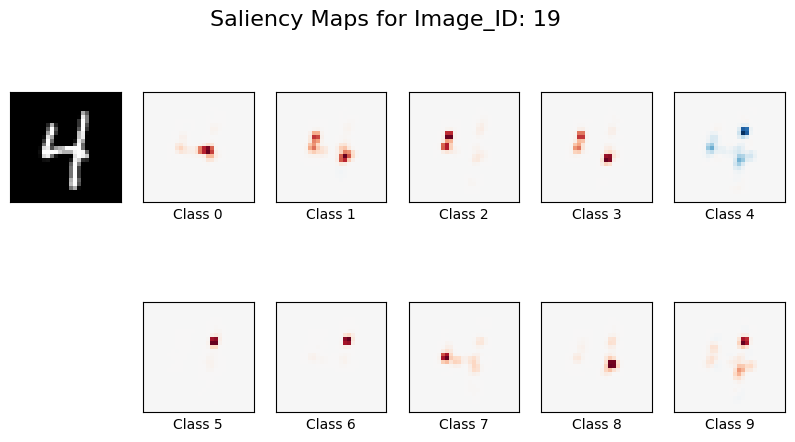

In [13]:
class MLFlowQueryAndLogSaliency(MLFlowXAI):

    def __init__(self):
        
        super(MLFlowQueryAndLogSaliency,self).__init__()
        self.saliency_run_id = None
        self.saliency_params= {}
        
    def query_run(self,filter_string,order_by,exp_id):
        
        run = mlflow.search_runs(
            experiment_ids=exp_id,
            filter_string=filter_string,
            run_view_type=ViewType.ACTIVE_ONLY,
            order_by=order_by
        )
        return run
    
    def set_saliency_params(self,saliency_params):
        self.saliency_params = saliency_params
        
    def get_saliency_params(self):
        return self.saliency_params
    
    def log_saliency_maps(self, experiment_name, conf_score, image_id, eval_exp_id, eval_run_id, sal_run_id):

        experiment = self.init_experiment(experiment_name=experiment_name)

        sal_exp_id = experiment.experiment_id
        
        with mlflow.start_run(experiment_id=sal_exp_id,run_name=f"ImageID-{image_id}_saliency_maps",run_id=sal_run_id if sal_run_id != None else None) as run:
            
            # Adding new tag to modified run
            if sal_run_id != None:
                modified_run = {"Modified_run": "True"}
                mlflow.set_tags(modified_run)
                mlflow.set_tag("mlflow.runName", f"ImageID-{image_id}_saliency_maps")
                
            self.saliency_run_id = run.info.run_id
        
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset,
                            "Datasplit": self.datasplit,
                            "Evaluation_exp_id": eval_exp_id,
                            "Evaluation_run_id": eval_run_id})
            
            p = urlparse(experiment.artifact_location)
            
            smap_path = './saliency_map_np_arrays'
            if not os.path.exists(smap_path):
                os.makedirs(smap_path)
            
            mlflow.log_params(self.get_saliency_params())
            
            img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(image_id, X_test[image_id], image_classifier_mlp, gen_slidingWindow)
            
            np.save(os.path.join(smap_path,'image_saliency_maps.npy'), sal_maps)
            mlflow.log_artifact(smap_path)

            # Saliency maps saved under artifacts
            mlflow.log_figure(img_saliency,'Image_saliency_maps.png')

            mlflow.log_metric("Predicted_class_conf",conf_score)

            # Adding new metric and figure to modified run
            if sal_run_id != None:
                mlflow.log_metric("Predicted_class_conf_new",conf_score)
                mlflow.log_figure(img_saliency,'Image_saliency_maps_new.png')
                
            return sal_exp_id
    
    def get_saliency_run_id(self):
        return self.saliency_run_id


# Filter and query based on top_class_confidence_score metric and Top_conf_class tag

conf_threshold = 0.9
top_class = 4
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(top_class) + "'"

order = "DESC" # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

MLFlowQueryAndLogSaliencyObj = MLFlowQueryAndLogSaliency()
queried_runs = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by, 
                                                    exp_id = eval_exp_id)

# Generate and log saliency maps for the top queried image id from the Evaluation stage.

top_confScore = queried_runs["metrics.Predicted_class_conf"][0]
top_confScore_imgID = int(queried_runs["tags.Image_id"][0])
top_confScore_runID = str(queried_runs["run_id"][0])

saliency_params = gen_slidingWindow.get_config()

MLFlowQueryAndLogSaliencyObj.set_saliency_params(saliency_params)

sal_exp_id = MLFlowQueryAndLogSaliencyObj.log_saliency_maps("MLPClassifier - Saliency Map Generation",
                                            top_confScore,
                                            top_confScore_imgID,
                                            eval_exp_id,
                                            top_confScore_runID,
                                            None)

## Reproduce Saliency Map results by querying existing run <a name="ReproduceSaliencyMaps-mlp-mnist"></a>

Using the ``saliency_run_id`` of an existing Saliency Generation run, we can query the Saliency Algorithm parameters and reproduce the same results as part of a new MLFlow run.

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Predicted_class_conf,params.stride,params.window_size,params.threads,...,tags.mlflow.user,tags.framework,tags.mlflow.runName,tags.mlflow.source.name,tags.Evaluation_run_id,tags.mlflow.source.type,tags.version,tags.Evaluation_exp_id,tags.Dataset,tags.Experiment
0,306160ad13544a69aca4259be314ca4a,3,FINISHED,file:///home/local/KHQ/emily.veenhuis/Document...,2024-01-25 15:56:29.666000+00:00,2024-01-25 15:56:29.964000+00:00,1.0,"[1, 1]","[2, 2]",4,...,emily.veenhuis,sklearn,ImageID-19_saliency_maps,/home/local/KHQ/emily.veenhuis/Documents/cdao/...,8387849316f94ec9ab2f984a9efe39eb,LOCAL,v1,2,MNIST,MLPClassifier - Saliency Map Generation


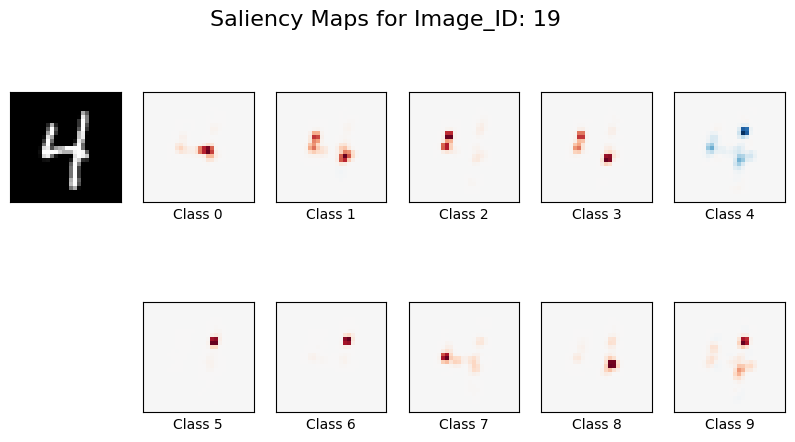

In [14]:
from IPython.display import display

filter_string = f"tags.Evaluation_run_id = '" + top_confScore_runID + "'"
order = "DESC" # or "ASC"
order_by = ["attribute.start_time " + order]

saliency_run_id = MLFlowQueryAndLogSaliencyObj.get_saliency_run_id()

# Querying Saliency parameters from an existing saliency generation run
queried_runs_saliency = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by,
                                                    exp_id = sal_exp_id)
display(queried_runs_saliency)

window_size = tuple(eval(queried_runs_saliency["params.window_size"][0]))
stride = tuple(eval(queried_runs_saliency["params.stride"][0]))
threads = int(queried_runs_saliency["params.threads"][0])

gen_slidingWindow_rep_test = SlidingWindowStack(
    window_size=window_size,
    stride=stride,
    threads=threads
)

img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(top_confScore_imgID, X_test[top_confScore_imgID], image_classifier_mlp, gen_slidingWindow_rep_test)

## Edit existing Saliency Generation run <a name="MLFlowEditSaliency-mlp-mnist"></a>

We use the `get_saliency_run_id` method to return the MLFlow Run ID of an existing saliency generation run. Instead of creating a new run like the example cell above, we edit an existing run to generate and update the saliency maps for the queried ``Image_ID``.


Name: MLPClassifier - Saliency Map Generation
Experiment_id: 3
Artifact Location: file:///home/local/KHQ/emily.veenhuis/Documents/cdao/xaitk-cdao/examples/mlflow/mlruns/3
Tags: {'version': 'v1', 'framework': 'sklearn', 'Experiment': 'MLPClassifier - Saliency Map Generation'}
Lifecycle_stage: active


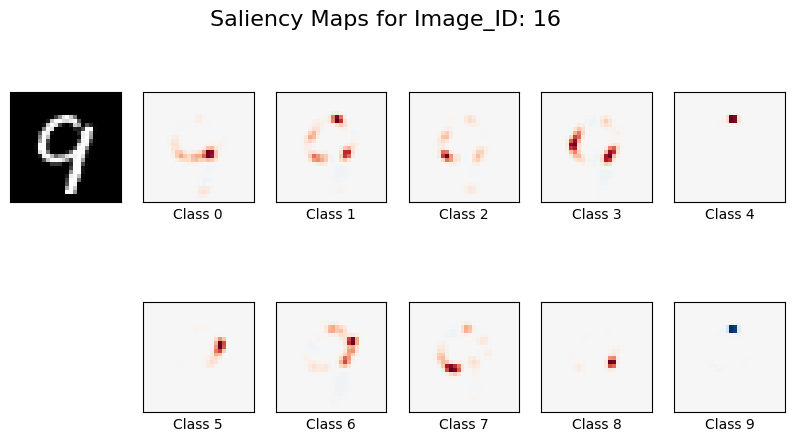

In [15]:
# Get Run ID of existing saliency generation run (in this case the most recent run)
existing_sal_run_id = MLFlowQueryAndLogSaliencyObj.get_saliency_run_id()

conf_threshold = 0.9
top_class = 9
filter_string = f"metrics.Predicted_class_conf >= " + str(conf_threshold) +" and tags.Predicted_class = '" + str(top_class) + "'"

order = "DESC" # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

queried_runs_new = MLFlowQueryAndLogSaliencyObj.query_run(filter_string = filter_string, 
                                                    order_by = order_by, 
                                                    exp_id = eval_exp_id)

top_confScore_new = queried_runs_new["metrics.Predicted_class_conf"][0]
top_confScore_imgID_new = int(queried_runs_new["tags.Image_id"][0])
top_confScore_runID_new = str(queried_runs_new["run_id"][0])

# Updated the existing run's tags, parameters and artifacts based on the new queried image
sal_exp_id = MLFlowQueryAndLogSaliencyObj.log_saliency_maps("MLPClassifier - Saliency Map Generation",
                                            top_confScore_new,
                                            top_confScore_imgID_new,
                                            eval_exp_id,
                                            top_confScore_runID_new,
                                            existing_sal_run_id)

## Permanently delete existing MLFlow experiment <a name="MLFlowDeleteExperiment-mlp-mnist"></a>

While interacting with the MLFlow UI, the process of deleting an existing experiment does not permanently delete the contents of the experiment from the backend store. So, after deleting an experiment using the UI, it is important to run the following command from a terminal for permanent deletion:

> `mlflow gc`